# Case Cientista de Dados - Previsão do Load Factor

Esse notebook faz parte do case solicitado pela GOL, para prever o Load Factor das três principais linhas aéreas brasileiras.

O projeto, como solicitado, dividido em 2 partes, estas dividas em:
- Parte 1
  - Criação do Spark Session / Carregamento dos Dados
  - Tratamento dos Dados
  - Análise Exploratória
- Parte 2
  - Treino e teste
  - Previsão próximos 90 dias
  - Previsão com as companhias separadas
- Etapa teste
  - Cross Validator

#Parte 1: Criação do Spark Session / Carregamento dos Dados


Aqui foi criado o ambiente do PySpark.

É feita a leitura dos baixados do site da ANAC, do período de 01/01/2023 até 31/07/2025, que foram zipados em um único arquivo.

É feita a extração para um único DataFrame Spark, ficando pronto para a etapa de leitura e transformação.

In [ ]:
#!pip install pyspark

In [1]:
!apt-get update -y
!apt-get install -y openjdk-17-jre-headless


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [2]:
import os

os.environ.pop("SPARK_HOME", None)  # mantém sem SPARK_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

!java -version


openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)


In [3]:
!pip install -U pyspark==3.5.1


In [4]:
#criando a SparkSession

from pyspark.sql import SparkSession

sessao_spark = SparkSession\
                    .builder\
                    .appName('Load Factor (ANAC)')\
                    .getOrCreate()

sessao_spark

In [5]:
#extraindo os arquivos zipados

zip_name = '/content/basica202.zip'

import zipfile, os

extract_dir = 'csv_extraidos'

with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(extract_dir)

os.listdir(extract_dir)


['basica2024-07.txt',
 'basica2025-01.txt',
 'basica2024-05.txt',
 'basica2023-12.txt',
 'basica2023-02.txt',
 'basica2023-03.txt',
 'basica2023-10.txt',
 'basica2024-11.txt',
 'basica2025-04.txt',
 'basica2024-09.txt',
 'basica2024-02.txt',
 'basica2024-06.txt',
 'basica2023-05.txt',
 'basica2023-04.txt',
 'basica2025-02.txt',
 'basica2024-10.txt',
 'basica2024-12.txt',
 'basica2023-06.txt',
 'basica2023-11.txt',
 'basica2024-03.txt',
 'basica2024-08.txt',
 'basica2025-05.txt',
 'basica2025-06.txt',
 'basica2023-07.txt',
 'basica2023-01.txt',
 'basica2025-07.txt',
 'basica2024-04.txt',
 'basica2023-09.txt',
 'basica2025-03.txt',
 'basica2023-08.txt',
 'basica2024-01.txt']

In [6]:
# Caminho da pasta onde estão os arquivos

caminho = '/content/csv_extraidos/*.txt'

df = sessao_spark.read.csv(
    caminho,
    sep=';',
    header=True,
    inferSchema=True,
    encoding='latin1'
)

df.show(5)
print('Total de linhas:', df.count())

+---------+----------+---------------+---------------+--------------------+-------+--------------------+------+-----------+-----+-----+--------------------+-----------+-------------+-----------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+-----------------+--------------------+------------------------+-----------------+---------------------+-------------+-------------+----------------+----------------------+---------------------+-----------------+-------------------+---------------+-------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------+-------------------+----------------------+--------------------------+-------------------+-----------------------+-------------------+--------------+--------------+--------------------+--------------------+------------+----------------+--------------+--------------------+--------+-----------------

#Parte 1: Tratamento de dados

Depois do carregamento dos dados, é realizada a etapa de tratamento.

Foi feita a impressão do schema das colunas, contagem do número de linhas e colunas do DataFrame.

\
Depois fora aplicados os filtros solicitados no case:
- Companhias aéreas: Azul (AD), GOL (G3) e LATAM (JJ).  
- Tipo de grupo: apenas voos REGULAR .  
- Natureza da etapa: apenas vôos DOMÉSTICA.

\
Foi feita a contagem de valores nulos, com isso, foi feita a remoção da coluna nr_escala_destino, que não tinha nenhum registro, foi feita também a substituição dos valores nulos da coluna nr_chave por 0.

\
Foi feita a remoção de serviços tipo CARGUEIRO.

\
Depois desses tratamentos, foi iniciada a fase exploratória.



In [7]:
#import de spark functions

import pyspark.sql.functions as f
import pandas as pd

In [8]:
#schema das colunas
df.printSchema()

root
 |-- id_basica: integer (nullable = true)
 |-- id_empresa: integer (nullable = true)
 |-- sg_empresa_icao: string (nullable = true)
 |-- sg_empresa_iata: string (nullable = true)
 |-- nm_empresa: string (nullable = true)
 |-- nm_pais: string (nullable = true)
 |-- ds_tipo_empresa: string (nullable = true)
 |-- nr_voo: integer (nullable = true)
 |-- nr_singular: string (nullable = true)
 |-- id_di: integer (nullable = true)
 |-- cd_di: string (nullable = true)
 |-- ds_di: string (nullable = true)
 |-- ds_grupo_di: string (nullable = true)
 |-- dt_referencia: date (nullable = true)
 |-- nr_ano_referencia: integer (nullable = true)
 |-- nr_semestre_referencia: integer (nullable = true)
 |-- nm_semestre_referencia: string (nullable = true)
 |-- nr_trimestre_referencia: integer (nullable = true)
 |-- nm_trimestre_referencia: string (nullable = true)
 |-- nr_mes_referencia: integer (nullable = true)
 |-- nm_mes_referencia: string (nullable = true)
 |-- nr_semana_referencia: integer (nul

In [9]:
#quantidade de linhas
df.count()

2439018

In [10]:
#quantidade de colunas
len(df.columns)

111

In [11]:
#filtros de empresa, vôos domésticos e grupo regular

df_iata = df.filter(f.col('sg_empresa_iata').isin(['AD','G3','JJ']))
df_grupo = df_iata.filter(f.col('ds_grupo_di').isin('REGULAR'))
df_filtrado = df_grupo.filter(f.col('ds_natureza_etapa').isin('DOMÉSTICA'))

df_filtrado.select('ds_natureza_etapa', 'ds_grupo_di', 'sg_empresa_iata').distinct().show()

+-----------------+-----------+---------------+
|ds_natureza_etapa|ds_grupo_di|sg_empresa_iata|
+-----------------+-----------+---------------+
|        DOMÉSTICA|    REGULAR|             JJ|
|        DOMÉSTICA|    REGULAR|             AD|
|        DOMÉSTICA|    REGULAR|             G3|
+-----------------+-----------+---------------+



In [12]:
#contagem de valores nulos

df_filtrado.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df_filtrado.columns]).show()

+---------+----------+---------------+---------------+----------+-------+---------------+------+-----------+-----+-----+-----+-----------+-------------+-----------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+-----------------+--------------------+------------------------+-----------------+---------------------+-------------+-------------+-------------+----------------------+---------------------+-----------------+---------------+---------------+-------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------+-------------------+----------------------+--------------------------+-------------------+-----------------------+-------------------+--------------+--------------+-------------------+-------------------+------------+----------------+--------------+--------------------+--------+---------------+---------------+-------------------+----

In [13]:
#remoção da coluna nr_escala_destino, que não tem nenhum registro

df_filtrado = df_filtrado.drop('nr_escala_destino')
df_filtrado.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df_filtrado.columns]).show()

+---------+----------+---------------+---------------+----------+-------+---------------+------+-----------+-----+-----+-----+-----------+-------------+-----------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+-----------------+--------------------+------------------------+-----------------+---------------------+-------------+-------------+-------------+----------------------+---------------------+-----------------+---------------+---------------+-------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------+-------------------+----------------------+--------------------------+-------------------+-----------------------+-------------------+--------------+--------------+-------------------+-------------------+------------+----------------+--------------+--------------------+--------+---------------+---------------+-------------------+----

In [14]:
#subtituição dos nulo da coluna nr_chave por 0

df_fill = df_filtrado.na.fill({'nr_chave': 0})
df_fill.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df_fill.columns]).show()

+---------+----------+---------------+---------------+----------+-------+---------------+------+-----------+-----+-----+-----+-----------+-------------+-----------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+-----------------+--------------------+------------------------+-----------------+---------------------+-------------+-------------+-------------+----------------------+---------------------+-----------------+---------------+---------------+-------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------+-------------------+----------------------+--------------------------+-------------------+-----------------------+-------------------+--------------+--------------+-------------------+-------------------+------------+----------------+--------------+--------------------+--------+---------------+---------------+-------------------+----

In [15]:
#remoção de serviços do tipo cargueiro

df_fill = df_fill.filter(f.col('ds_servico_tipo_linha') != 'CARGUEIRO')
df_fill.show(5)

+---------+----------+---------------+---------------+--------------------+-------+--------------------+------+-----------+-----+-----+--------------------+-----------+-------------+-----------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+-----------------+--------------------+------------------------+-----------------+---------------------+-------------+-------------+---------------+----------------------+---------------------+-----------------+-------------------+---------------+-------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------+-------------------+----------------------+--------------------------+-------------------+-----------------------+-------------------+--------------+--------------+-------------------+-------------------+------------+----------------+--------------+--------------------+--------+-------------------+

In [16]:
#seleciona as colunas e cria a coluna passageiros_totais e load factor raw(1 = 100% vendido)
df_metricas = df_fill.select(
                        'sg_empresa_iata',
                        'dt_partida_real',
                        'nr_assentos_ofertados',
                        'nr_passag_pagos',
                        'nr_passag_gratis',
                        'km_distancia',
                        'nr_ask',
                        'nr_rpk')\
                    .withColumn('total_passageiros', f.col('nr_passag_pagos') + f.col('nr_passag_gratis'))\
                    .withColumn('load_factor_raw',f.when(f.col('nr_ask') > 0, f.col('nr_rpk') / f.col('nr_ask')).otherwise(f.lit(None)))\
                    .withColumn('load_factor_raw',f.when(f.col('load_factor_raw') > 1, 1).otherwise(f.col('load_factor_raw')))


df_metricas.show(5)


#nr_ask = assentos disponíveis por km voado (A = assentos)

#nr_rpk = passageiros por km voado (RP = passageiros)

+---------------+---------------+---------------------+---------------+----------------+------------+------+------+-----------------+------------------+
|sg_empresa_iata|dt_partida_real|nr_assentos_ofertados|nr_passag_pagos|nr_passag_gratis|km_distancia|nr_ask|nr_rpk|total_passageiros|   load_factor_raw|
+---------------+---------------+---------------------+---------------+----------------+------------+------+------+-----------------+------------------+
|             JJ|     2025-01-07|                  220|            209|               0|        1705|375100|356345|              209|              0.95|
|             JJ|     2025-01-03|                  172|            146|               1|        1705|293260|248930|              147|0.8488372093023255|
|             G3|     2025-01-17|                  186|            142|               9|         458| 85188| 65036|              151|0.7634408602150538|
|             G3|     2025-01-28|                  153|             95|           

In [17]:
#agregado por dia e por companhia aérea calculando o load factordiário
df_diario = df_metricas.filter(f.year("dt_partida_real") != 2022)\
                       .filter(~((f.year("dt_partida_real") == 2025) & (f.month("dt_partida_real") == 8)))\
                       .groupBy('sg_empresa_iata', 'dt_partida_real')\
                       .agg(f.sum('nr_ask').alias('ASK_dia'),
                            f.sum('nr_rpk').alias('RPK_dia'),
                            f.sum('nr_assentos_ofertados').alias('assentos_ofertados_dia'),
                            f.sum('total_passageiros').alias('total_passageiros_dia'),
                            f.count('*').alias('qtd_etapas_dia'))\
                       .withColumn('load_factor_dia', f.when(f.col('ASK_dia') > 0, f.col('RPK_dia') / f.col('ASK_dia')).otherwise(f.lit(None)))\
                       .orderBy('dt_partida_real')

df_diario.show(10, truncate=False)


#nr_ask = assentos disponíveis por km voado (A = assentos)

#nr_rpk = passageiros por km voado (RP = passageiros)


+---------------+---------------+---------+---------+----------------------+---------------------+--------------+------------------+
|sg_empresa_iata|dt_partida_real|ASK_dia  |RPK_dia  |assentos_ofertados_dia|total_passageiros_dia|qtd_etapas_dia|load_factor_dia   |
+---------------+---------------+---------+---------+----------------------+---------------------+--------------+------------------+
|AD             |2023-01-01     |59549727 |46974525 |58555                 |46774                |443           |0.7888285533198163|
|JJ             |2023-01-01     |115149799|92654525 |103498                |80674                |580           |0.8046433932550764|
|G3             |2023-01-01     |76365825 |63485579 |74458                 |61949                |430           |0.8313349459656856|
|JJ             |2023-01-02     |136311250|113883450|126445                |101583               |705           |0.8354662582875588|
|AD             |2023-01-02     |94686253 |82152052 |99785           

#Parte 1: Análise Exploratória

Foi realizada uma análise para entender o histórico do **Load Factor**(LF) das três principais companhias.

\
Foram calculados indicadores básicos por companhia:
- Média e mediana do Load Factor diário
- Desvio padrão
- Valores mínimo e máximo observados
- Número de dias com registros válidos

Essas métricas ajudam a comparar a dispersão entre as companhias.

\
Foi analisada a evolução do **Load Factor** médio mensal para cada companhia.  
O gráfico de linha mostra como o LF varia ao longo do tempo:
- Tendências de crescimento ou queda
- Padrões de alta demanda em determinados meses
- Diferenças entre as companhias

\
Também foi avaliado o comportamento do LF por dia da semana.  
Este mostra quais dias apresentam maior ou menor ocupação, mostrando:
- Preferência de passageiros
- Possíveis diferenças estratégicas entre as companhias

\
Foi construída a distribuição acumulada do LF para cada cia.  
Esse gráfico mostra a proporção de dias em que a ocupação foi menor ou igual a determinado valor, permitindo avaliar:
- Consistência da ocupação
- Frequência de dias com baixo ou alto LF
- Comparação entre a estabilidade operacional das companhias



In [18]:
#mostramos a media, mediana, min e max e desvio padrão do load factor por companhia
stats = (df_diario.groupBy('sg_empresa_iata')
                  .agg(
                      f.expr('percentile_approx(load_factor_dia, 0.5)').alias('mediana_LF'),
                      f.avg('load_factor_dia').alias('media_LF'),
                      f.stddev('load_factor_dia').alias('desvio_LF'),
                      f.min('load_factor_dia').alias('min_LF'),
                      f.max('load_factor_dia').alias('max_LF'),
                      f.count('*').alias('dias_observados'))
                 .orderBy('sg_empresa_iata'))

stats.show(truncate=False)


+---------------+------------------+------------------+--------------------+------------------+------------------+---------------+
|sg_empresa_iata|mediana_LF        |media_LF          |desvio_LF           |min_LF            |max_LF            |dias_observados|
+---------------+------------------+------------------+--------------------+------------------+------------------+---------------+
|AD             |0.8060307223710778|0.8028961265845862|0.04479931729430311 |0.594594831857773 |0.9125452976512146|943            |
|G3             |0.8307009782350132|0.8270735039669118|0.03917999061318815 |0.6738733095569768|0.9218499555722492|943            |
|JJ             |0.8281323096703899|0.8218210757878136|0.043029290127786994|0.6772073683295403|0.9181995038296593|943            |
+---------------+------------------+------------------+--------------------+------------------+------------------+---------------+



In [19]:
#cria o df com o load factor medio por Mês para cada uma das 3 companhias
df_mes = (df_diario.withColumn('ano_mes', f.date_format('dt_partida_real', 'yyyy-MM'))
                   .groupBy('sg_empresa_iata', 'ano_mes')
                   .agg(f.avg('load_factor_dia').alias('load_factor_medio'))
                   .orderBy('sg_empresa_iata', 'ano_mes'))

df_mes.show(31, truncate=False)

+---------------+-------+------------------+
|sg_empresa_iata|ano_mes|load_factor_medio |
+---------------+-------+------------------+
|AD             |2023-01|0.8250120501077559|
|AD             |2023-02|0.7754205642073975|
|AD             |2023-03|0.7774696530118067|
|AD             |2023-04|0.780985526812884 |
|AD             |2023-05|0.7833439035497245|
|AD             |2023-06|0.7932855937250061|
|AD             |2023-07|0.8182693948077843|
|AD             |2023-08|0.8043386252560963|
|AD             |2023-09|0.7968505288987484|
|AD             |2023-10|0.7875591702357126|
|AD             |2023-11|0.7819611467677381|
|AD             |2023-12|0.794345166715157 |
|AD             |2024-01|0.8319994861060092|
|AD             |2024-02|0.7322378520725188|
|AD             |2024-03|0.7681142036870852|
|AD             |2024-04|0.7564665958243608|
|AD             |2024-05|0.7925869159508199|
|AD             |2024-06|0.8123654008422588|
|AD             |2024-07|0.8203933155636536|
|AD       

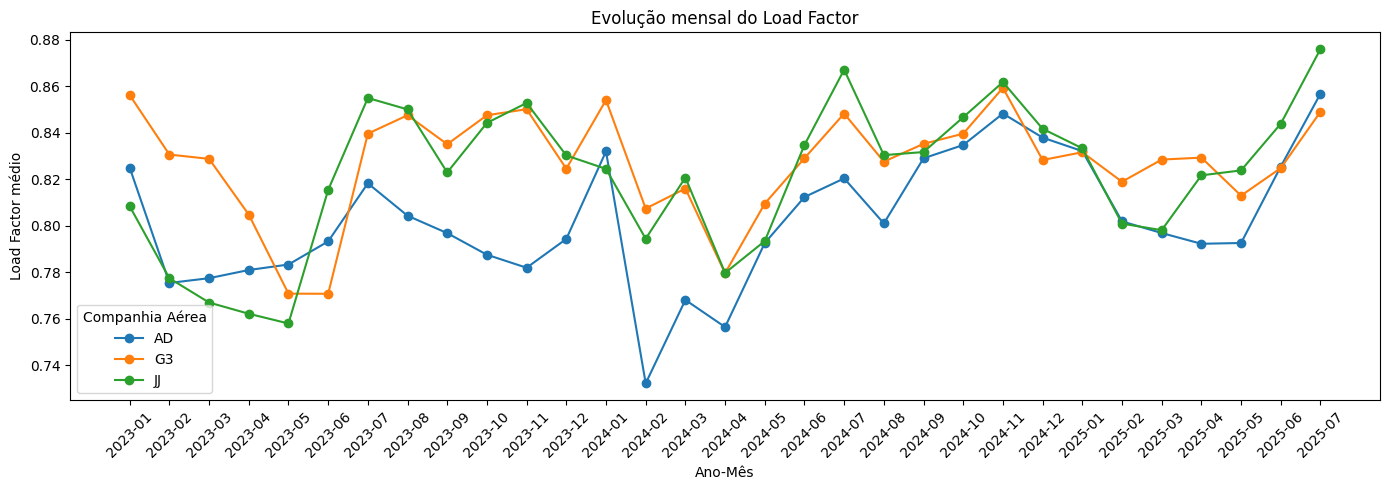

In [20]:
#gráfico de linha mostrando o comportamento do LF ao longo dos meses para cada companhia
#itera por cada linha de cada companhia
import matplotlib.pyplot as plt

df_mes = (df_diario.withColumn('ano_mes', f.date_format('dt_partida_real','yyyy-MM'))
                   .groupBy('sg_empresa_iata','ano_mes')
                   .agg(f.avg('load_factor_dia').alias('lf_medio'))
                   .orderBy('sg_empresa_iata','ano_mes')
                   .toPandas())

plt.figure(figsize=(14,5))
for c, l in df_mes.groupby('sg_empresa_iata'):
    plt.plot(l['ano_mes'], l['lf_medio'], marker='o', label=c)

plt.xticks(rotation=45)
plt.title('Evolução mensal do Load Factor')
plt.xlabel('Ano-Mês')
plt.ylabel('Load Factor médio')
plt.legend(title='Companhia Aérea')
plt.tight_layout()
plt.show()



In [21]:
#cria o df com o load factor medio por dia da semana para cada uma das 3 companhias
df_semana = (df_diario.withColumn('dia_semana', f.date_format('dt_partida_real', 'E'))
                     .groupBy('sg_empresa_iata', 'dia_semana')
                     .agg(f.avg('load_factor_dia').alias('load_factor_medio'),
                          f.count('*').alias('qtd_etapas'))
                     .orderBy('sg_empresa_iata', 'dia_semana'))

df_semana.show(21, truncate=False)


+---------------+----------+------------------+----------+
|sg_empresa_iata|dia_semana|load_factor_medio |qtd_etapas|
+---------------+----------+------------------+----------+
|AD             |Fri       |0.7943422445570681|134       |
|AD             |Mon       |0.7940779199767584|135       |
|AD             |Sat       |0.8215111516096183|134       |
|AD             |Sun       |0.8069017826032735|135       |
|AD             |Thu       |0.8042046902609647|135       |
|AD             |Tue       |0.8002906474481268|135       |
|AD             |Wed       |0.7990189766214587|135       |
|G3             |Fri       |0.8358034111091364|134       |
|G3             |Mon       |0.8412272322284239|135       |
|G3             |Sat       |0.823393264706816 |134       |
|G3             |Sun       |0.8501852386341553|135       |
|G3             |Thu       |0.8225005610435697|135       |
|G3             |Tue       |0.8051527731148846|135       |
|G3             |Wed       |0.8112894518786702|135      

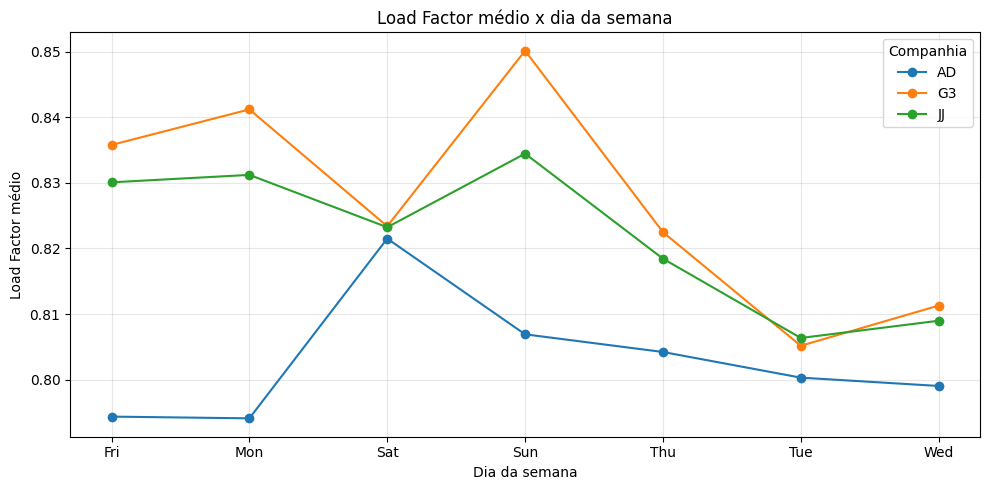

In [22]:
#mostra no gráfico a mesma informação da célula anterior, sendo a Azul a companhia com o menor valor médio de load factor
p_df_semana = df_semana.toPandas()

plt.figure(figsize=(10,5))
for c, l in p_df_semana.groupby('sg_empresa_iata'):
    plt.plot(l['dia_semana'], l['load_factor_medio'], marker="o", label=c)

plt.title('Load Factor médio x dia da semana')
plt.xlabel('Dia da semana')
plt.ylabel('Load Factor médio')
plt.legend(title='Companhia')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


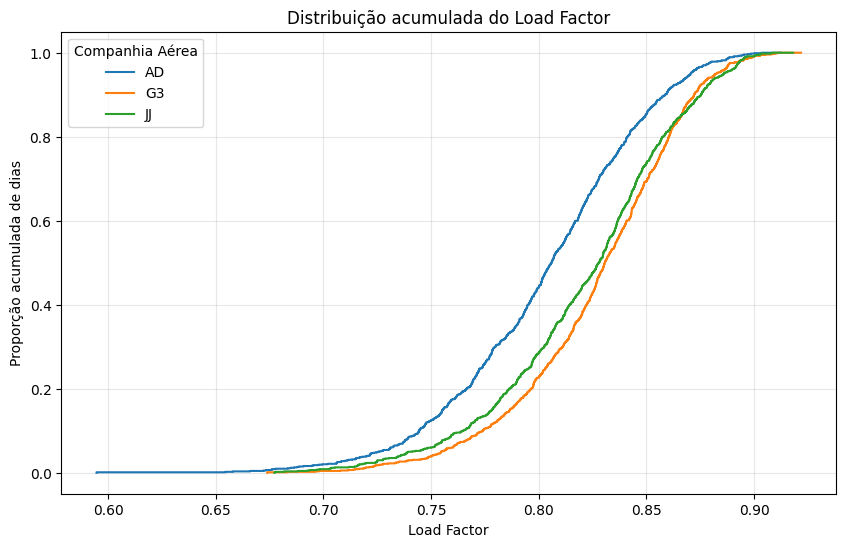

In [23]:
#mostra como se distribuem os valores do LF em comparação com a proporção de dias. Dá pra ver quantos 'dias' cada companhia vôou com qual ocupação
import numpy as np

p_df = df_diario.select('sg_empresa_iata','load_factor_dia').toPandas()

plt.figure(figsize=(10,6))
for c, l in p_df.groupby('sg_empresa_iata'):
    vals = np.sort(l['load_factor_dia'].dropna())
    y = np.arange(1, len(vals)+1) / len(vals)
    plt.step(vals, y, label=c)

plt.title('Distribuição acumulada do Load Factor')
plt.xlabel('Load Factor')
plt.ylabel('Proporção acumulada de dias')
plt.legend(title='Companhia Aérea')
plt.grid(alpha=0.3)
plt.show()


A análise revelou:


   - A Azul (AD) tende a apresentar menores valores médios em comparação à GOL (G3) e LATAM (JJ).
   - A GOL e a LATAM mantêm valores mais altos e consistentes, indicando maior eficiência no aproveitamento dos assentos.


   - Foi observada sazonalidade, com picos em determinados meses como férias.
   - Há tendência de queda em períodos de baixa demanda.

   - Aos finais de semana, as companhias podem apresentar variações maiores, possivelmente ligadas ao turismo.

   - A Azul (AD) tem maior proporção de dias com Load Factor abaixo de 0.8, mostrando maior volatilidade.
   - A GOL (G3) e a LATAM (JJ) concentram boa parte dos dias com Load Factor acima de 0.8, o que mostra maior estabilidade operacional.

\
 Em resumo:  
- **Azul (AD)** → valores médios mais baixos e maior dispersão.  
- **GOL (G3)** → boa consistência, ocupação elevada na maior parte dos dias.  
- **LATAM (JJ)** → desempenho semelhante à GOL, mas com algumas variações sazonais.  




#Parte 2: Treino e teste


**Estratégia adotada**

\
Antes de aplicar os modelos, foi realizada a separação do dataset em **treino** e **teste**.  
- **Treino**: 70%
- **Teste**: 30%
- A divisão foi feita de forma aleatória com randomSplit do MLlib.


#### Objetivo
- Garantir que o modelo aprenda com parte dos dados (treino) e seja validado em dados não vistos (teste).  
- As métricas obtidas nessa validação ajudarão na escolha do modelo mais adequado para projetar o Load Factor nos próximos 90 dias.



In [24]:
#pega a data minima e salva na var, depois cria as colunas de datas(ano, mes, dia...), e por último exibe o resultado do df
min_date = df_diario.select(f.date_format(f.min('dt_partida_real'), 'yyyy-MM-dd')).first()
min_date_str = min_date[0]

df_temporal = df_diario.withColumn('dia_mes', f.dayofmonth('dt_partida_real')) \
                       .withColumn('mes', f.month('dt_partida_real')) \
                       .withColumn('ano', f.year('dt_partida_real')) \
                       .withColumn('dia_semana', f.dayofweek('dt_partida_real')) \
                       .withColumn('dias_inicio', f.datediff('dt_partida_real', f.lit(min_date_str)))

df_temporal.select('dt_partida_real',
                   'sg_empresa_iata',
                   'load_factor_dia',
                   'dia_mes',
                   'mes',
                   'ano',
                   'dia_semana',
                   'dias_inicio')\
           .show()

+---------------+---------------+------------------+-------+---+----+----------+-----------+
|dt_partida_real|sg_empresa_iata|   load_factor_dia|dia_mes|mes| ano|dia_semana|dias_inicio|
+---------------+---------------+------------------+-------+---+----+----------+-----------+
|     2023-01-01|             JJ|0.8046433932550764|      1|  1|2023|         1|          0|
|     2023-01-01|             AD|0.7888285533198163|      1|  1|2023|         1|          0|
|     2023-01-01|             G3|0.8313349459656856|      1|  1|2023|         1|          0|
|     2023-01-02|             AD|0.8676238566542495|      2|  1|2023|         2|          1|
|     2023-01-02|             G3| 0.864306037388488|      2|  1|2023|         2|          1|
|     2023-01-02|             JJ|0.8354662582875588|      2|  1|2023|         2|          1|
|     2023-01-03|             JJ|0.8398111581235896|      3|  1|2023|         3|          2|
|     2023-01-03|             AD|0.8599567395568535|      3|  1|2023| 

In [25]:
#salva as cols de data numa lista, cria o vetor com o assembles e usa no df
from pyspark.ml.feature import VectorAssembler

feature_cols = ['dia_mes', 'mes', 'ano', 'dia_semana', 'dias_inicio']
label_col = 'load_factor_dia'

v_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_ml = v_assembler.transform(df_temporal).select('features', label_col)
df_ml.show(5, truncate=False)


+------------------------+------------------+
|features                |load_factor_dia   |
+------------------------+------------------+
|[1.0,1.0,2023.0,1.0,0.0]|0.8046433932550764|
|[1.0,1.0,2023.0,1.0,0.0]|0.7888285533198163|
|[1.0,1.0,2023.0,1.0,0.0]|0.8313349459656856|
|[2.0,1.0,2023.0,2.0,1.0]|0.8676238566542495|
|[2.0,1.0,2023.0,2.0,1.0]|0.864306037388488 |
+------------------------+------------------+
only showing top 5 rows



In [26]:
#separação de treino e teste
train_data, test_data = df_ml.randomSplit([0.7, 0.3], seed=42)

print(f'Linhas de treino: {train_data.count()}')
print(f'Linhas de teste: {test_data.count()}')


Linhas de treino: 2035
Linhas de teste: 794


####**REGRESSÃO LINEAR**

**Metodologia**
- Modelo simples e interpretável.
- Tenta ajustar uma relação linear entre as features e o Load Factor.

**Resultados**
- A comparação entre valores reais e previstos mostrou que o modelo não conseguiu capturar bem a variabilidade do Load Factor.
- Métricas: RMSE alto, R² baixo → indicando baixa efetividade.

**Conclusão**
- Útil como baseline inicial.
- Não adequado para capturar relações não-lineares presentes nos dados.



In [27]:
#cria e treina o modelo de regressão linear
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol=label_col)
lr_modelo = lr.fit(train_data)

In [28]:
#previsão, avaliação com a métrica erro medio e coeficiente de determinação
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_modelo.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='rmse')
rmse = evaluator_rmse.evaluate(predictions)
print(f'Erro médio (RMSE): {rmse:.4f}')

evaluator_r2 = RegressionEvaluator(labelCol=label_col,predictionCol='prediction',metricName='r2')
r2 = evaluator_r2.evaluate(predictions)
print(f'Coeficiente de Determinação (R²): {r2:.4f}')

predictions.select('load_factor_dia', 'prediction').show(10)

Erro médio (RMSE): 0.0408
Coeficiente de Determinação (R²): 0.1055
+------------------+------------------+
|   load_factor_dia|        prediction|
+------------------+------------------+
|0.8313349459656856|0.7858089953815579|
|0.7987321470677567|0.8100783807949483|
|0.8328298478252159|0.8100783807949483|
|0.8085041359926636|  0.79183301514513|
|0.8418213246031206|0.8008515180499671|
|0.8553886168649047|0.8008515180499671|
| 0.837780106866373| 0.816102400557611|
|0.7960794992868705|0.7791598961021009|
|0.7441542877579391|0.7944107786097447|
|0.8297921157092637|0.7944107786097447|
+------------------+------------------+
only showing top 10 rows



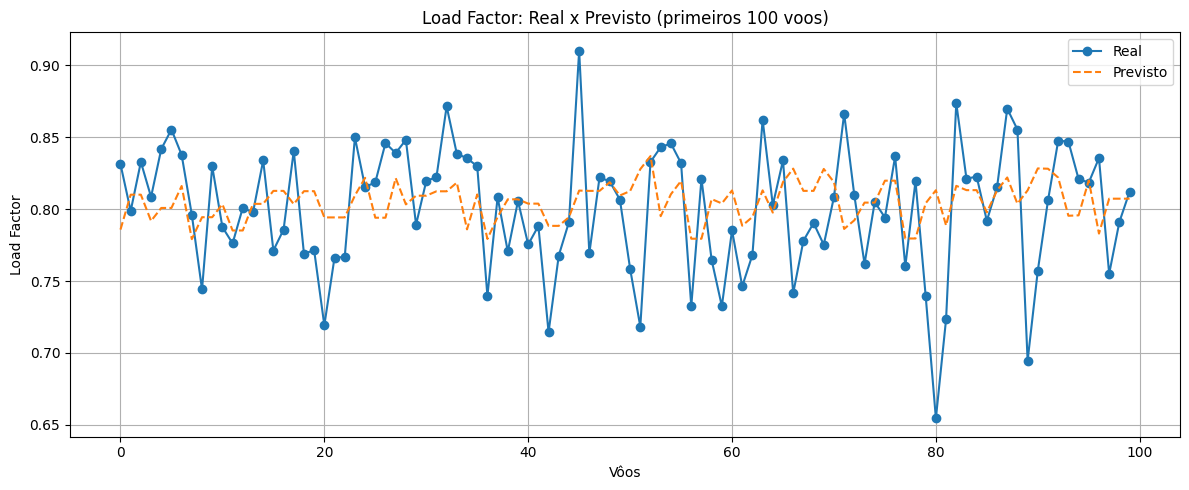

In [29]:
#o gráfico mostra a comparação entre o previsto pelo modelo e o real (só os 100 primeiros vôos), isso mostra que o modelo não está bom e vamos tentar outra abprdagem

df_plot = predictions.select('load_factor_dia', 'prediction').toPandas()
n = 100

plt.figure(figsize=(12, 5))
plt.plot(df_plot['load_factor_dia'][:n].values, label='Real', marker='o', linestyle='-')
plt.plot(df_plot['prediction'][:n].values, label='Previsto',
         linestyle='--')
plt.title('Load Factor: Real x Previsto (primeiros 100 voos)')
plt.xlabel('Vôos')
plt.ylabel('Load Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


####**RANDOM FOREST**

**Metodologia**
- Algoritmo baseado em múltiplas árvores de decisão.
- Configuração: numTrees=100, maxDepth=5.
- Esperava-se capturar melhor padrões não-lineares entre as variáveis.

**Resultados**
- O modelo melhorou em relação à regressão linear.
- Ainda assim, mostrou pouca efetividade em prever corretamente dias com valores extremos de Load Factor.

**Conclusão**
- Se mostrou mais performático em relação ao baseline.
- Funciona bem para dados tabulares, mas ainda limitado para projeções de séries temporais.



In [30]:
#cria, treina e faz previsão no modelo de floresta
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol=label_col, numTrees=100, maxDepth=5, seed=42)
rf_modelo = rf.fit(train_data)
rf_predictions = rf_modelo.transform(test_data)


In [31]:
#avaliação com a métrica erro medio e coeficiente de determinação
rmse_rf = evaluator_rmse.evaluate(rf_predictions)
print(f'Random Forest - RMSE: {rmse_rf:.4f}')

r2_rf = evaluator_r2.evaluate(rf_predictions)
print(f'Random Forest - R²: {r2_rf:.4f}')


Random Forest - RMSE: 0.0345
Random Forest - R²: 0.3586


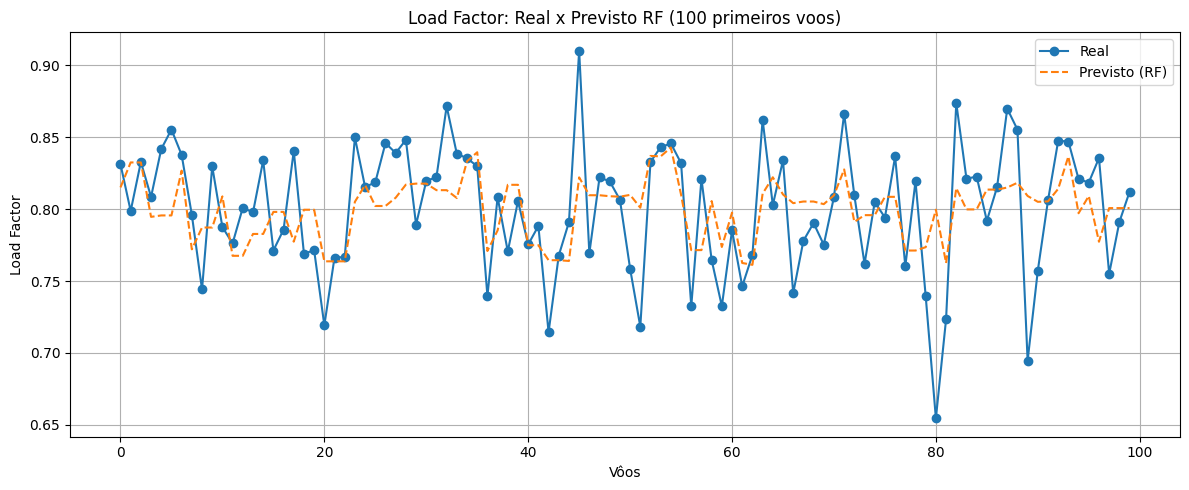

In [32]:
#o gráfico mostra a comparação entre o previsto pelo modelo e o real (só os 100 primeiros vôos), isso mostra que o modelo não está bom e vamos tentar outra abprdagem
df_rf_plot = rf_predictions.select('load_factor_dia', 'prediction').toPandas()

n = 100

plt.figure(figsize=(12, 5))
plt.plot(df_rf_plot['load_factor_dia'][:n].values, label='Real', marker='o', linestyle='-')
plt.plot(df_rf_plot['prediction'][:n].values, label='Previsto (RF)', linestyle='--')
plt.title('Load Factor: Real x Previsto RF (100 primeiros voos)')
plt.xlabel('Vôos')
plt.ylabel('Load Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



####**GBTREGRESSOR**

**Metodologia**
- Constrói árvores de forma sequencial, corrigindo erros das anteriores.
- Configuração: maxIter=100, maxDepth=5.
- Esperava-se maior precisão em relação à Random Forest.

**Resultados**
- Apresentou melhor performance entre os modelos testados.
- Métricas (RMSE e R²) indicaram melhora significativa em relação à regressão linear.
- Capturou mais adequadamente a tendência geral do Load Factor.

**Conclusão**
- Foi o modelo que apresentou melhor ajuste.
- Recomendado para a projeção futura de 90 dias.
- Pode ser refinado com ajustes de hiperparâmetros e inclusão de variáveis externas como feriados.





In [33]:
#cria, treina e faz previsão no modelo de GBTRegressor
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol='features',labelCol=label_col, maxIter=100, maxDepth=5, seed=42)
gbt_modelo = gbt.fit(train_data)
gbt_predictions = gbt_modelo.transform(test_data)


In [34]:
#avaliação com a métrica erro medio e coeficiente de determinação
rmse_gbt = evaluator_rmse.evaluate(gbt_predictions)
print(f'GBTRegressor - RMSE: {rmse_gbt:.4f}')

r2_gbt = evaluator_r2.evaluate(gbt_predictions)
print(f'GBTRegressor - R²: {r2_gbt:.4f}')


GBTRegressor - RMSE: 0.0332
GBTRegressor - R²: 0.4088


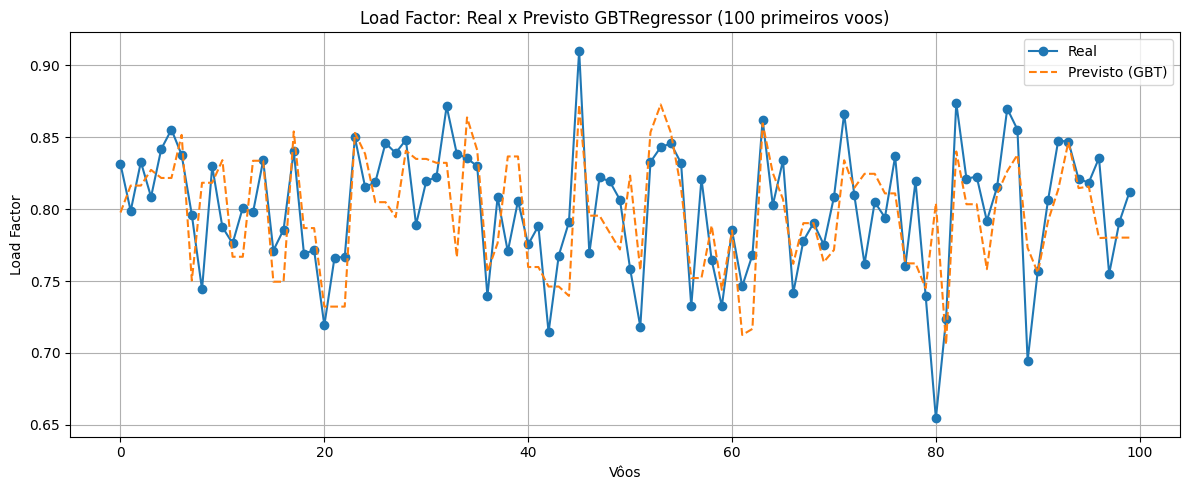

In [35]:
#o gráfico mostra a comparação entre o previsto pelo modelo e o real (só os 100 primeiros vôos)
df_gbt_plot = gbt_predictions.select('load_factor_dia', 'prediction').toPandas()

n = 100

plt.figure(figsize=(12, 5))
plt.plot(df_gbt_plot['load_factor_dia'][:n].values, label='Real', marker='o', linestyle='-')
plt.plot(df_gbt_plot['prediction'][:n].values, label='Previsto (GBT)', linestyle='--')
plt.title('Load Factor: Real x Previsto GBTRegressor (100 primeiros voos)')
plt.xlabel('Vôos')
plt.ylabel('Load Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Em resumo:
- **Regressão Linear** → baseline fraco, não explica bem os dados.  
- **Random Forest** → melhora, mas ainda limitado.  
- **GBT Regressor** → melhor modelo entre os testados, escolhido para projeções futuras.



#Parte 2: Previsão próximos 90 dias


Após a etapa de treino e teste, aplicamos o modelo com melhor desempenho **(GBT Regressor)** para gerar previsões do **Load Factor** para os 90 dias subsequentes à última data disponível no dataset.

\
**Modelo de predição**
- Foi criado um conjunto futuro de datas correspondente ao período de 90 dias à frente.
- Essas datas foram transformadas em features pelo VectorAssembler, utilizando a mesma estrutura aplicada nos dados de treino e teste.
- O modelo GBT, previamente treinado, foi então aplicado sobre esse conjunto para gerar as previsões.




In [36]:
#passa as datas pro pandas, calcula a data min e max, calcula a max + 91 dias, considera domingo como dia 1
from datetime import timedelta

max_date_str = df_temporal.select(f.date_format(f.max('dt_partida_real'), 'yyyy-MM-dd')).first()[0]
max_date = pd.to_datetime(max_date_str)

min_date_str = df_temporal.select(f.date_format(f.min('dt_partida_real'), 'yyyy-MM-dd')).first()[0]
min_date = pd.to_datetime(min_date_str)

future_dates = [max_date + timedelta(days=i) for i in range(1, 90)]

df_futuro = pd.DataFrame({'dt_partida_real': future_dates,
                          'dia_mes': [d.day for d in future_dates],
                          'mes': [d.month for d in future_dates],
                          'ano': [d.year for d in future_dates],
                          'dia_semana': [d.weekday() + 1 for d in future_dates],
                          'dias_inicio': [(d - min_date).days for d in future_dates]})

df_futuro.head()


,dt_partida_real,dia_mes,mes,ano,dia_semana,dias_inicio
0,2025-08-01,1,8,2025,5,943
1,2025-08-02,2,8,2025,6,944
2,2025-08-03,3,8,2025,7,945
3,2025-08-04,4,8,2025,1,946
4,2025-08-05,5,8,2025,2,947


In [37]:
#transforma novamente o df de pandas para spark
from pyspark.sql import Row

df_futuro['dt_partida_real'] = df_futuro['dt_partida_real'].astype(str)

spark_rows = [Row(**row._asdict()) for row in df_futuro.itertuples(index=False)]
df_futuro_spark = sessao_spark.createDataFrame(spark_rows)

df_futuro_spark.show(5)


+---------------+-------+---+----+----------+-----------+
|dt_partida_real|dia_mes|mes| ano|dia_semana|dias_inicio|
+---------------+-------+---+----+----------+-----------+
|     2025-08-01|      1|  8|2025|         5|        943|
|     2025-08-02|      2|  8|2025|         6|        944|
|     2025-08-03|      3|  8|2025|         7|        945|
|     2025-08-04|      4|  8|2025|         1|        946|
|     2025-08-05|      5|  8|2025|         2|        947|
+---------------+-------+---+----+----------+-----------+
only showing top 5 rows



In [38]:
#criacão do modelo
df_futuro_features = v_assembler.transform(df_futuro_spark)
df_futuro_features.select('dt_partida_real', 'features').show(5, truncate=False)


+---------------+--------------------------+
|dt_partida_real|features                  |
+---------------+--------------------------+
|2025-08-01     |[1.0,8.0,2025.0,5.0,943.0]|
|2025-08-02     |[2.0,8.0,2025.0,6.0,944.0]|
|2025-08-03     |[3.0,8.0,2025.0,7.0,945.0]|
|2025-08-04     |[4.0,8.0,2025.0,1.0,946.0]|
|2025-08-05     |[5.0,8.0,2025.0,2.0,947.0]|
+---------------+--------------------------+
only showing top 5 rows



In [39]:
#mostra a previsão pros proximos 90 dias
df_previsoes_futuro = gbt_modelo.transform(df_futuro_features)

df_previsoes_futuro.show(5)

+---------------+-------+---+----+----------+-----------+--------------------+------------------+
|dt_partida_real|dia_mes|mes| ano|dia_semana|dias_inicio|            features|        prediction|
+---------------+-------+---+----+----------+-----------+--------------------+------------------+
|     2025-08-01|      1|  8|2025|         5|        943|[1.0,8.0,2025.0,5...|0.8109641735514074|
|     2025-08-02|      2|  8|2025|         6|        944|[2.0,8.0,2025.0,6...|0.8132704939639184|
|     2025-08-03|      3|  8|2025|         7|        945|[3.0,8.0,2025.0,7...|0.8518618231150208|
|     2025-08-04|      4|  8|2025|         1|        946|[4.0,8.0,2025.0,1...|0.8331409708234463|
|     2025-08-05|      5|  8|2025|         2|        947|[5.0,8.0,2025.0,2...|0.8458696383500144|
+---------------+-------+---+----+----------+-----------+--------------------+------------------+
only showing top 5 rows



In [40]:
df_previsoes_futuro.select('dt_partida_real', 'prediction').show(10, truncate=False)

+---------------+------------------+
|dt_partida_real|prediction        |
+---------------+------------------+
|2025-08-01     |0.8109641735514074|
|2025-08-02     |0.8132704939639184|
|2025-08-03     |0.8518618231150208|
|2025-08-04     |0.8331409708234463|
|2025-08-05     |0.8458696383500144|
|2025-08-06     |0.8023903223422237|
|2025-08-07     |0.7937445493942207|
|2025-08-08     |0.8400914496326749|
|2025-08-09     |0.8705741064799177|
|2025-08-10     |0.8815641828148807|
+---------------+------------------+
only showing top 10 rows



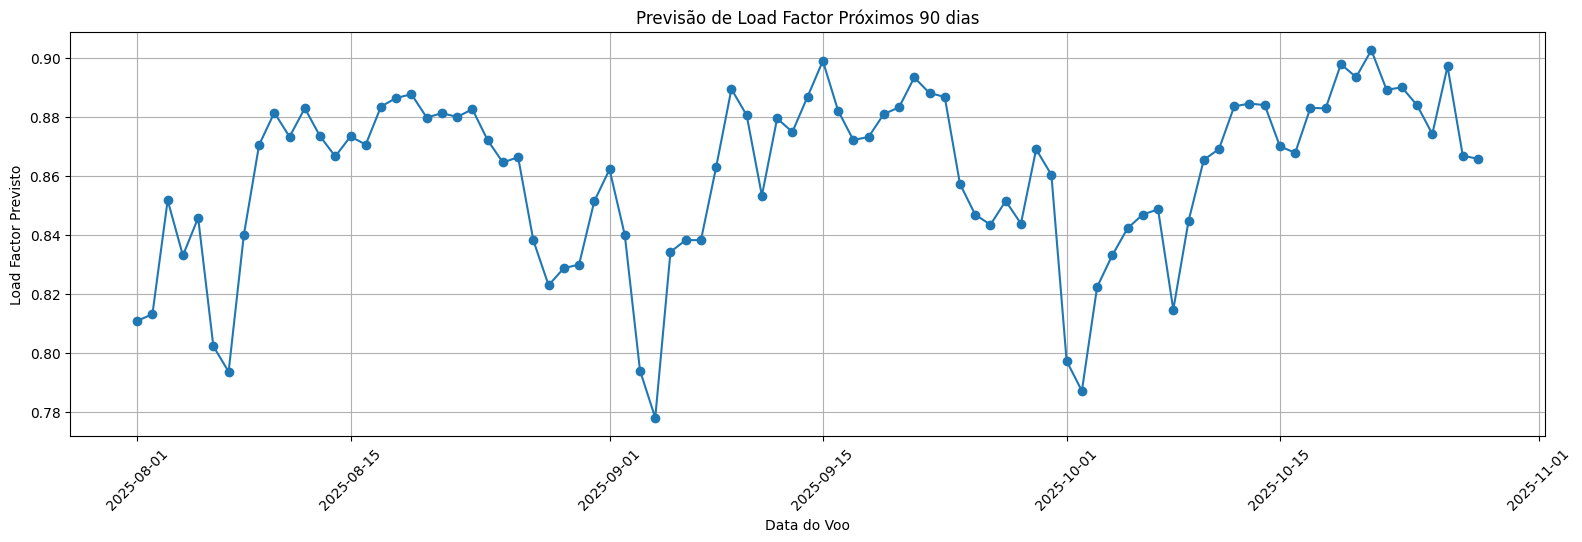

In [41]:
#passa a data pro pandas, ordena, e plota a previsão
df_plot_futuro = df_previsoes_futuro.select('dt_partida_real', 'prediction').toPandas()

df_plot_futuro['dt_partida_real'] = pd.to_datetime(df_plot_futuro['dt_partida_real'])

df_plot_futuro = df_plot_futuro.sort_values('dt_partida_real')

plt.figure(figsize=(16, 5))
plt.plot(df_plot_futuro['dt_partida_real'], df_plot_futuro['prediction'], marker='o', linestyle='-')
plt.title('Previsão de Load Factor Próximos 90 dias')
plt.xlabel('Data do Voo')
plt.ylabel('Load Factor Previsto')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


#### Resultados
- Foi obtida uma série prevista de Load Factor para os próximos 90 dias.
- As previsões indicam que:
  - Tendências sazonais identificadas na análise exploratória, como variações por dia da semana e por mês foram vistos.
  - Os valores médios se mantem dentro do intervalo histórico, o que mostra consistência do modelo.

- Os gráficos comparativos mostram a evolução temporal e o comportamento esperado do LF.

#### Conclusão
- As previsões fornecem uma visão de curto prazo que pode auxiliar a área de Precificação da GOL para criar estratégias de oferta e demanda.
- Embora o modelo escolhido (GBT) tenha se mostrado o mais eficaz neste case, melhorias podem ser alcançadas com inclusão de variáveis externas, como feriados.


#Parte 2: Companhias separadas


Após a geração da previsão agregada, realizamos a separação por companhia aérea, aplicando o modelo individualmente para cada uma.

\
**Metodologia**
- Os dados foram divididos por sg_empresa_iata.
- Para cada cia, foi criado um conjunto futuro (90 dias a frente).
- O modelo foi aplicado a cada conjunto, gerando previsões para cada companhia.


In [42]:
#cria a var cias, dicionario de modelos e lista de resultados
cias = ['G3', 'AD', 'JJ']
modelos_cia = {}
resultados_avaliacao = []

In [43]:
#criação do modelo
#usa o assembler pra criar a coluna de features, divide os dados de treino e teste e avalia as métricas rmse e r2
for c in cias:
    print(f'\nCompanhia: {c}')

    df_cia = df_temporal.filter(f.col('sg_empresa_iata') == c)
    df_cia_ml = v_assembler.transform(df_cia).select('features', label_col)

    train, test = df_cia_ml.randomSplit([0.7, 0.3], seed=42)

    modelo = gbt.fit(train)
    modelos_cia[c] = modelo

    predicoes = modelo.transform(test)

    evaluator_rmse = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='rmse')
    rmse = evaluator_rmse.evaluate(predicoes)
    evaluator_r2 = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='r2')
    r2 = evaluator_r2.evaluate(predicoes)

    resultados_avaliacao.append({
        'Companhia': c,
        'RMSE': rmse,
        'R²': r2})

    print(f'RMSE: {rmse:.4f} | R²: {r2:.4f}')



Companhia: G3
RMSE: 0.0245 | R²: 0.5995

Companhia: AD
RMSE: 0.0310 | R²: 0.4986

Companhia: JJ
RMSE: 0.0271 | R²: 0.6076


In [44]:
#cria o df spark com as datas futuras e a var vazia pra guardar as previsões
spark_rows = [Row(**row._asdict()) for row in df_futuro.itertuples(index=False)]
df_futuro_spark = sessao_spark.createDataFrame(spark_rows)

df_previsoes_cias = None

In [45]:
#predição
#cria col de cia, cria features, usa o modelo pra gerar previsões e adiciona as previsões na var
for c in cias:
    print(f'\nCompanhia: {c}')

    df_futuro_cia = df_futuro_spark.withColumn('sg_empresa_iata', f.lit(c))

    df_futuro_features = v_assembler.transform(df_futuro_cia)
    modelo = modelos_cia[c]
    df_previsoes = modelo.transform(df_futuro_features)

    df_previsoes_formatado = df_previsoes.select('dt_partida_real', 'sg_empresa_iata', 'prediction')

    if df_previsoes_cias is None:
        df_previsoes_cias = df_previsoes_formatado
    else:
        df_previsoes_cias = df_previsoes_cias.union(df_previsoes_formatado)

    df_previsoes_cias.orderBy('dt_partida_real', 'sg_empresa_iata').show(5, truncate=False)




Companhia: G3
+---------------+---------------+------------------+
|dt_partida_real|sg_empresa_iata|prediction        |
+---------------+---------------+------------------+
|2025-08-01     |G3             |0.7949423438607077|
|2025-08-02     |G3             |0.810356998872526 |
|2025-08-03     |G3             |0.8072466951936332|
|2025-08-04     |G3             |0.8266242708555089|
|2025-08-05     |G3             |0.8165773706269138|
+---------------+---------------+------------------+
only showing top 5 rows


Companhia: AD
+---------------+---------------+------------------+
|dt_partida_real|sg_empresa_iata|prediction        |
+---------------+---------------+------------------+
|2025-08-01     |AD             |0.828877855528857 |
|2025-08-01     |G3             |0.7949423438607077|
|2025-08-02     |AD             |0.7887644121401625|
|2025-08-02     |G3             |0.810356998872526 |
|2025-08-03     |AD             |0.8629410030124021|
+---------------+---------------+-----------

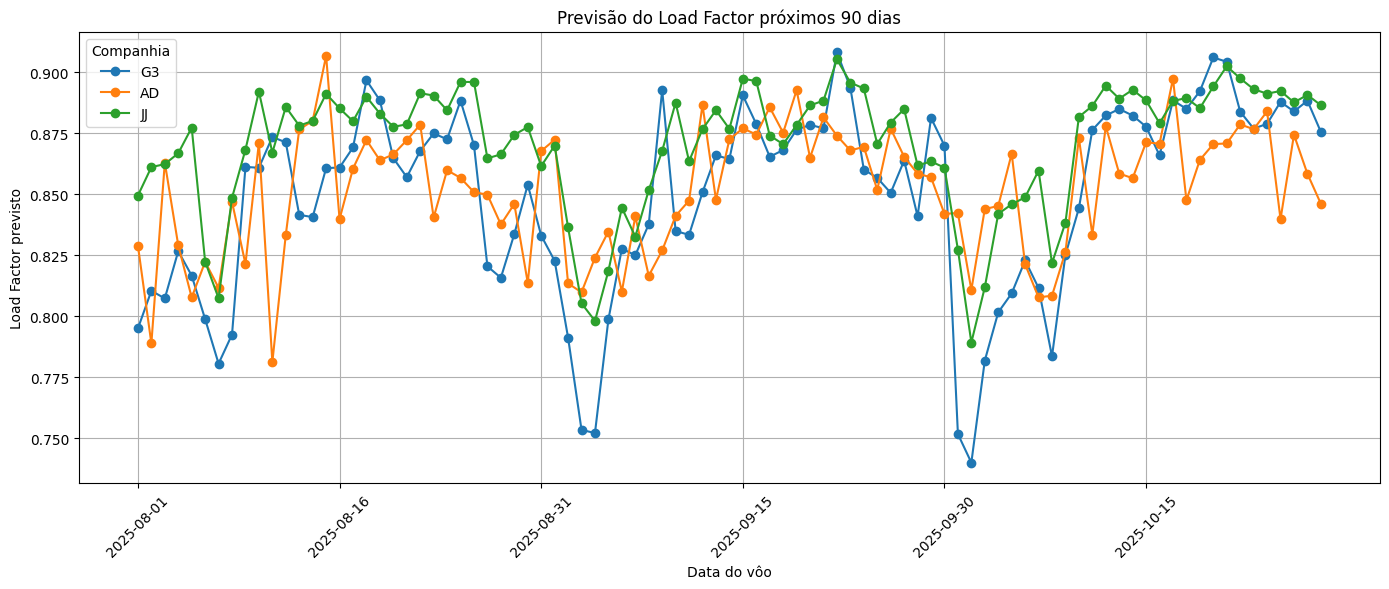

In [46]:
#plot do gráfico de predição para as 3 cias
df_previsoes_pd = df_previsoes_cias.toPandas()
df_previsoes_pd['dt_partida_real'] = pd.to_datetime(df_previsoes_pd['dt_partida_real'])

plt.figure(figsize=(14, 6))

for c in df_previsoes_pd['sg_empresa_iata'].unique():
    df_cia = df_previsoes_pd[df_previsoes_pd['sg_empresa_iata'] == c]
    plt.plot(df_cia['dt_partida_real'], df_cia['prediction'], marker='o', label=c)

datas = df_previsoes_pd['dt_partida_real'].sort_values().unique()
plt.xticks(datas[::15], rotation=45)

plt.title('Previsão do Load Factor próximos 90 dias')
plt.xlabel('Data do vôo')
plt.ylabel('Load Factor previsto')
plt.legend(title='Companhia')
plt.grid(True)
plt.tight_layout()
plt.show()



### **Resultados**
- **GOL (G3):**
  - Apresentou Load Factor alto, mantendo valores próximos à média histórica.
  - Mostrou estabilidade e menor dispersão nas previsões.

- **Azul (AD):**
  - Os valores previstos mostram maior variabilidade.
  - Em comparação às outras companhias, a Azul apresentou menores níveis médios de ocupação, conforme já observado na análise exploratória.

- **LATAM (JJ):**
  - Resultados próximos aos da GOL, mas, com maior oscilação.
  - As previsões mostram comportamento que acompanha o padrão histórico.

#### **Conclusão**
- A análise separada reforça os achados da análise exploratória:
  - A **Azul** tende a operar com menor LF médio.
  - A **GOL** e a **LATAM** apresentam níveis mais elevados e consistentes de Load Factor.
- Essa informação é muito importante para a área de Receitas e Precificação, permitindo a criação de estratégias para o negócio.


#Etapa teste: CROSS VALIDATOR



Esta etapa foi criada como modelo de treino e teste, com o objetivo de aumentar a acertividade do modelo de previsão, porém, não pode ser testado devido á falta de processamento na hora do .fit do modelo.

In [ ]:
# #grid de parametros pra testar o cross validator
# from pyspark.ml.tuning import ParamGridBuilder

# param_grid = ParamGridBuilder() \
#     .addGrid(gbt.maxDepth, [3, 5, 7]) \
#     .addGrid(gbt.maxIter, [50, 100]) \
#     .build()


In [ ]:
# #divide o treino em folds para testar com combinações de parametros diferentes(evaluator rmse)
# from pyspark.ml.tuning import CrossValidator

# cv = CrossValidator(
#     estimator=gbt,
#     estimatorParamMaps=param_grid,
#     evaluator=evaluator_rmse,
#     numFolds=3,
#     parallelism=2)

In [ ]:
# #treino do modelo usando o CV
# cv_model = cv.fit(train_data)

